In [1]:
import pandas as pd
from darts import TimeSeries, concatenate
import matplotlib.pyplot as plt

In [2]:
def load_target_series():
    target = pd.read_csv('https://raw.githubusercontent.com/KITmetricslab/RESPINOW-Hub/main/data/icosari/sari/target-icosari-sari.csv')

    ts_target = TimeSeries.from_group_dataframe(target, group_cols=['location', 'age_group'], 
                                             time_col='date', value_cols='value', 
                                             freq='7D', fillna_value=0)
    ts_target = concatenate(ts_target, axis=1)
    ts_target = ts_target.with_columns_renamed(ts_target.static_covariates.age_group.index, ts_target.static_covariates.age_group)
    
    return ts_target

In [3]:
def load_nowcast(forecast_date, probabilistic=True):
    filepath = f'../data/nowcasts/KIT-baseline/{forecast_date}-icosari-sari-KIT-baseline.csv'
    df = pd.read_csv(filepath)
    df = df[(df.type == 'quantile') & (df.horizon >= -3)]
    df = df.rename(columns={'target_end_date' : 'date'})
    
    if probabilistic==False:
        df = df[df['quantile'] == 0.5]
    
    all_nowcasts = []
    for age in df.age_group.unique():
        # print(age)
        df_temp = df[df.age_group == age]

        # transform nowcast into a TimeSeries object
        nowcast_age = TimeSeries.from_group_dataframe(df_temp, group_cols=['location', 'age_group', 'quantile'],
                              time_col='date', value_cols='value', 
                              freq='7D', fillna_value=0)

        nowcast_age = concatenate(nowcast_age, axis='sample')
        nowcast_age.static_covariates.drop(columns=['quantile'], inplace=True, errors='ignore')
        nowcast_age = nowcast_age.with_columns_renamed(nowcast_age.components, [age])

        all_nowcasts.append(nowcast_age)
    
    return concatenate(all_nowcasts, axis='component')

In [4]:
def make_target_paths(target_series, nowcast):
    # cut known truth series and append nowcasted values
    target_temp = target_series.drop_after(nowcast.start_time())
    
    # every entry is a multivariate timeseries (one sample path for each age group)
    # there is one entry per quantile level
    target_list = [concatenate([target_temp[age].append_values(nowcast[age].univariate_values(sample=i)) for age in nowcast.components], axis='component') 
                   for i in range(nowcast.n_samples)]
    
    return target_list

In [5]:
ts_target = load_target_series()

<Axes: xlabel='date'>

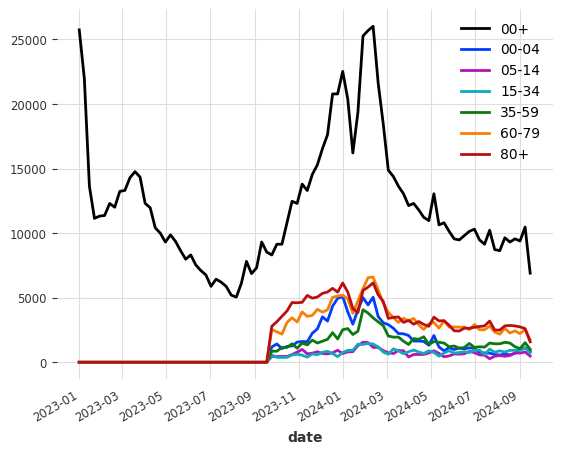

In [6]:
ts_target.plot()

In [7]:
ts_nowcast = load_nowcast('2024-01-25')

<Axes: xlabel='date'>

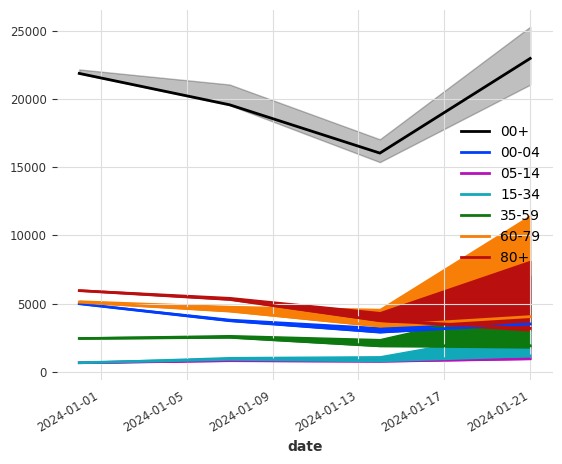

In [8]:
ts_nowcast.plot()

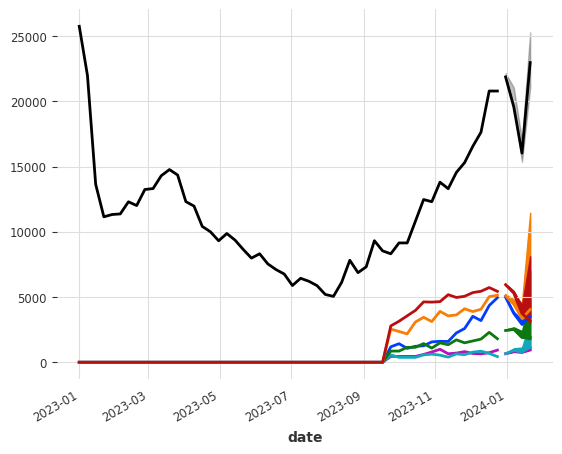

In [9]:
ts_target.drop_after(ts_nowcast.start_time()).plot(label='Truth')
ts_nowcast.plot(label='Nowcast')
plt.legend('')

In [10]:
target_list = make_target_paths(ts_target, ts_nowcast)

<Axes: xlabel='date'>

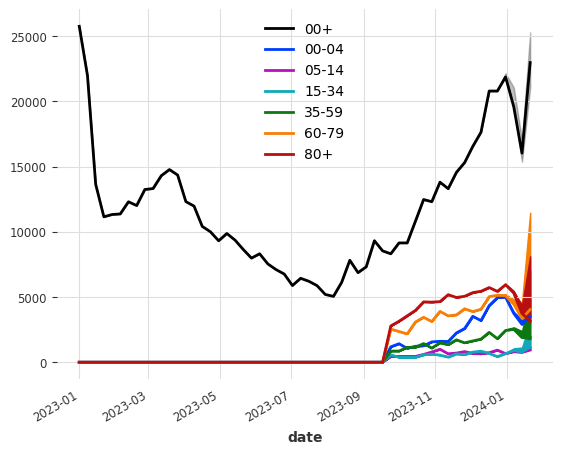

In [11]:
concatenate(target_list, axis='sample').plot()

### Plot multiple nowcasts

In [12]:
ts_target = load_target_series()

ts_nowcast1 = load_nowcast('2023-11-16')
ts_nowcast2 = load_nowcast('2024-01-25')
ts_nowcast3 = load_nowcast('2024-02-15')

target_list1 = make_target_paths(ts_target, ts_nowcast1)
target_list2 = make_target_paths(ts_target, ts_nowcast2)
target_list3 = make_target_paths(ts_target, ts_nowcast3)

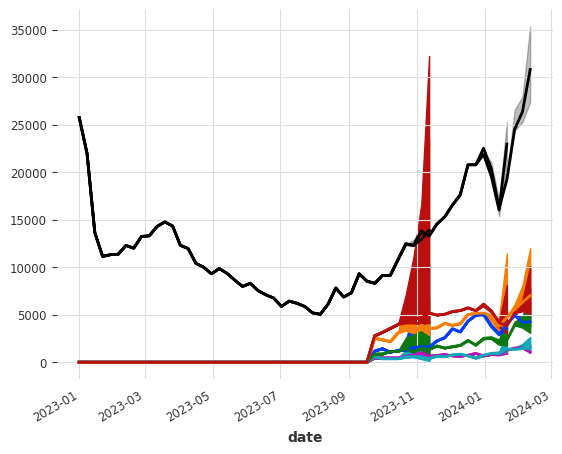

In [13]:
concatenate(target_list1, axis='sample').plot()
concatenate(target_list2, axis='sample').plot()
concatenate(target_list3, axis='sample').plot()
plt.legend('')

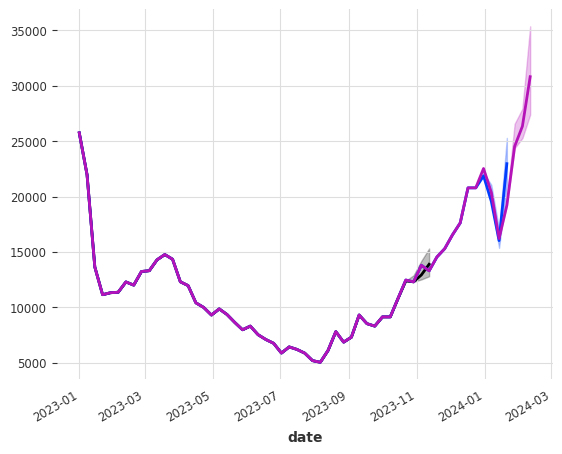

In [14]:
age = '00+'
concatenate(target_list1, axis='sample')[age].plot()
concatenate(target_list2, axis='sample')[age].plot()
concatenate(target_list3, axis='sample')[age].plot()
plt.legend('')

# Point predictions

In [15]:
ts_nowcast = load_nowcast('2024-01-25', probabilistic=False)

<Axes: xlabel='date'>

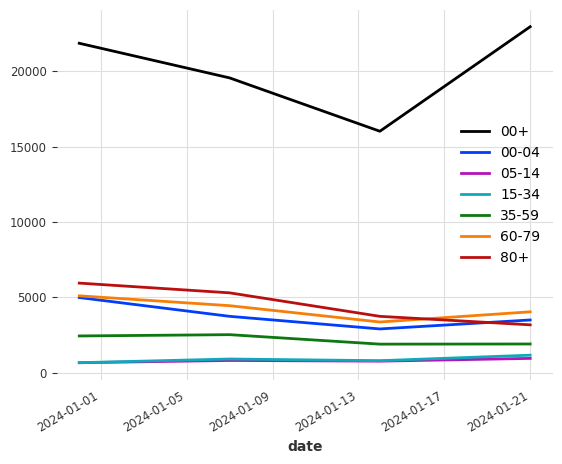

In [16]:
ts_nowcast.plot()

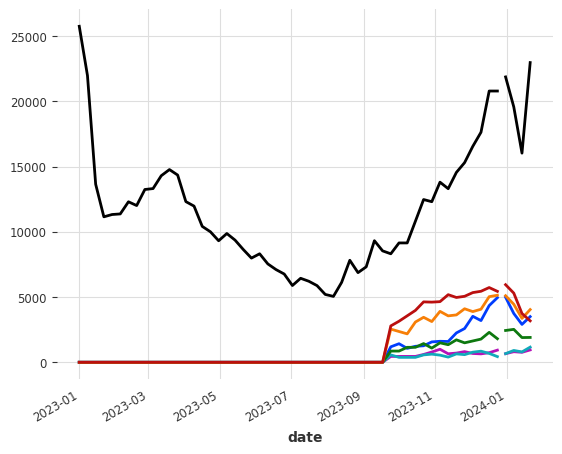

In [17]:
ts_target.drop_after(ts_nowcast.start_time()).plot(label='Truth')
ts_nowcast.plot(label='Nowcast')
plt.legend('')

### Plot multiple nowcasts

In [19]:
ts_target = load_target_series()

ts_nowcast1 = load_nowcast('2023-11-16', probabilistic=False)
ts_nowcast2 = load_nowcast('2024-01-25', probabilistic=False)
ts_nowcast3 = load_nowcast('2024-02-15', probabilistic=False)

target_list1 = make_target_paths(ts_target, ts_nowcast1)
target_list2 = make_target_paths(ts_target, ts_nowcast2)
target_list3 = make_target_paths(ts_target, ts_nowcast3)

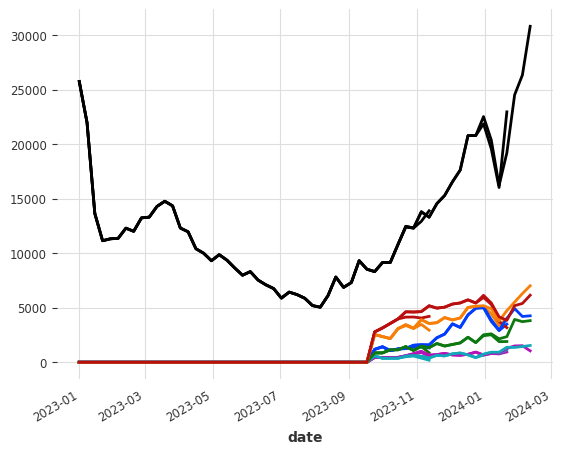

In [20]:
concatenate(target_list1, axis='sample').plot()
concatenate(target_list2, axis='sample').plot()
concatenate(target_list3, axis='sample').plot()
plt.legend('')